In [ ]:
%pip install pydub librosa matplotlib "numpy<2" "tensorflow<2.11.0" "tensorflow-gpu<2.11.0"

In [6]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성 (존재하지 않으면)
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

for file in files:
    # 파일 경로 설정
    m4a_path = os.path.join(input_dir, file)
    wav_path = os.path.join(output_dir, file.replace('.m4a', '.wav'))

    # m4a -> wav 변환
    sound = AudioSegment.from_file(m4a_path, format="m4a")
    sound.export(wav_path, format="wav")

In [3]:
import os
import librosa
import numpy as np

# RMS 값 추출 함수
def extract_rms_from_file(file_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms

# 시퀀스 데이터 생성 함수
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# 경로 및 파라미터 설정
wav_dir = './wav'
window_size = 20

# 전체 데이터 수집
X_all, y_all = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        try:
            rms = extract_rms_from_file(file_path)
            X, y = create_sequences(rms, window_size)
            X_all.append(X)
            y_all.append(y)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# 하나의 큰 배열로 합치기
X_total = np.concatenate(X_all, axis=0)
y_total = np.concatenate(y_all, axis=0)

# LSTM 입력 형식으로 변형
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')

총 시퀀스 개수: 820919, 입력 shape: (820919, 20, 1)


Epoch 1/50
20523/20523 [==============================] - 174s 8ms/step - loss: 2.0740e-05 - val_loss: 1.6642e-05
Epoch 2/50
20523/20523 [==============================] - 173s 8ms/step - loss: 1.5695e-05 - val_loss: 1.5110e-05
Epoch 3/50
20523/20523 [==============================] - 176s 9ms/step - loss: 1.5380e-05 - val_loss: 1.5535e-05
Epoch 4/50
20523/20523 [==============================] - 169s 8ms/step - loss: 1.5182e-05 - val_loss: 1.4753e-05
Epoch 5/50
20523/20523 [==============================] - 185s 9ms/step - loss: 1.4910e-05 - val_loss: 1.4481e-05
Epoch 6/50
20523/20523 [==============================] - 164s 8ms/step - loss: 1.4653e-05 - val_loss: 1.4640e-05
Epoch 7/50
20523/20523 [==============================] - 159s 8ms/step - loss: 1.4473e-05 - val_loss: 1.4478e-05
Epoch 8/50
20523/20523 [==============================] - 157s 8ms/step - loss: 1.4296e-05 - val_loss: 1.4679e-05
Epoch 9/50
20523/20523 [==============================] - 158s 8ms/step - loss: 1.4168e-

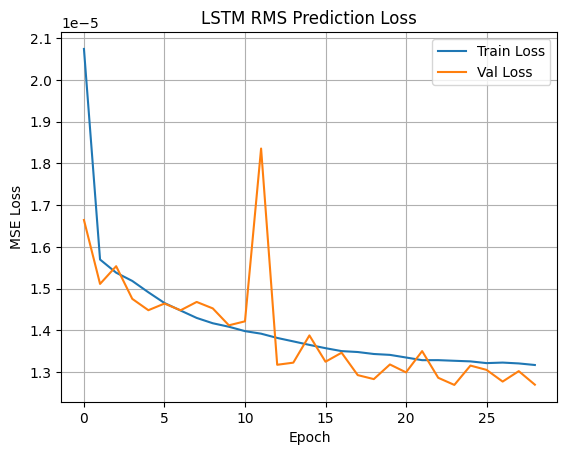

In [ ]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_total.shape[1], 1)),
    Dense(1)  # 다음 시점의 RMS 값을 예측
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_rms_model.h5')

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM RMS Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model # type: ignore
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

prediction_dir = './prediction'
os.makedirs(prediction_dir, exist_ok=True)

# 모델 예측 및 시각화 (각각의 음성 파일에 대해)
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        try:
            rms = extract_rms_from_file(file_path)
            X, y = create_sequences(rms, window_size)

            # LSTM 입력 형식으로 변형
            X = X.reshape((X.shape[0], X.shape[1], 1))

            # 모델 불러오기
            model = load_model('lstm_rms_model.h5')

            # 예측
            y_pred = model.predict(X)

            # 시각화 및 저장
            plt.figure(figsize=(10, 6))
            plt.plot(np.arange(len(rms)), rms, label='Original RMS')
            plt.plot(np.arange(window_size, len(rms)), y_pred, label='Predicted RMS', linestyle='--')
            plt.title(f'{filename} - RMS Prediction')
            plt.xlabel('Time (frames)')
            plt.ylabel('RMS')
            plt.legend()
            plt.grid(True)

            # 이미지 파일로 저장
            prediction_file_path = os.path.join(prediction_dir, f'{os.path.splitext(filename)[0]}_prediction.png')
            plt.savefig(prediction_file_path)
            plt.close()

        except Exception as e:
            print(f"Failed to process {filename}: {e}")

164/164 [==============================] - 1s 3ms/step
